In [13]:
import tensorflow as tf
import keras
from tensorflow.keras import layers


In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!ls

In [15]:
!ls PetImages

Cat  Dog


In [25]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [26]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)




Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [27]:
train_ds = train_ds.take(100)
val_ds = val_ds.take(20)

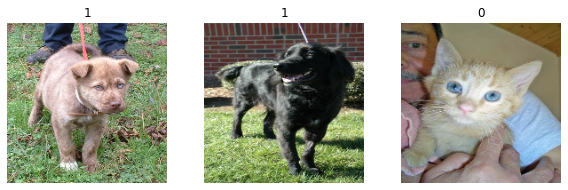

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

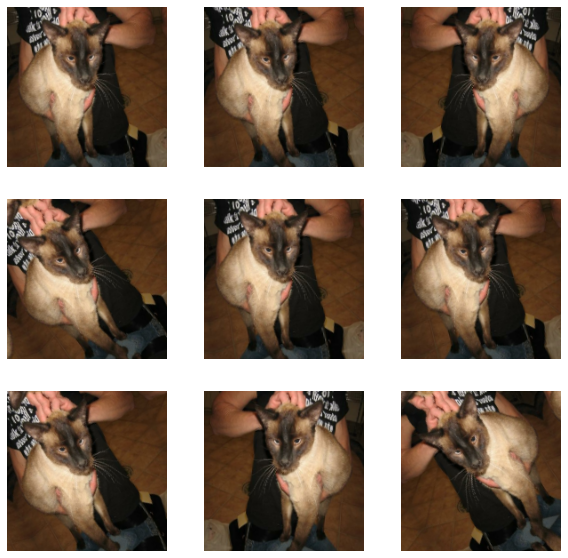

In [29]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")




In [30]:
# this uses GPU faster? decrease training from hours to seconds
# in colab go to runtime and select change runtime type
# inputs = keras.Input(shape=input_shape)
# x = data_augmentation(inputs)
# x = layers.experimental.preprocessing.Rescaling(1./255)(x)

# this uses CPU slower?
# augmented_train_ds = train_ds.map(
#   lambda x, y: (data_augmentation(x, training=True), y))

In [31]:
# so this gets 32 images at a time from disk to ram?
# ram is closer to CUP so faster execution. fetching from disk is slower
# why 32 though, colab has 12GB ram
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

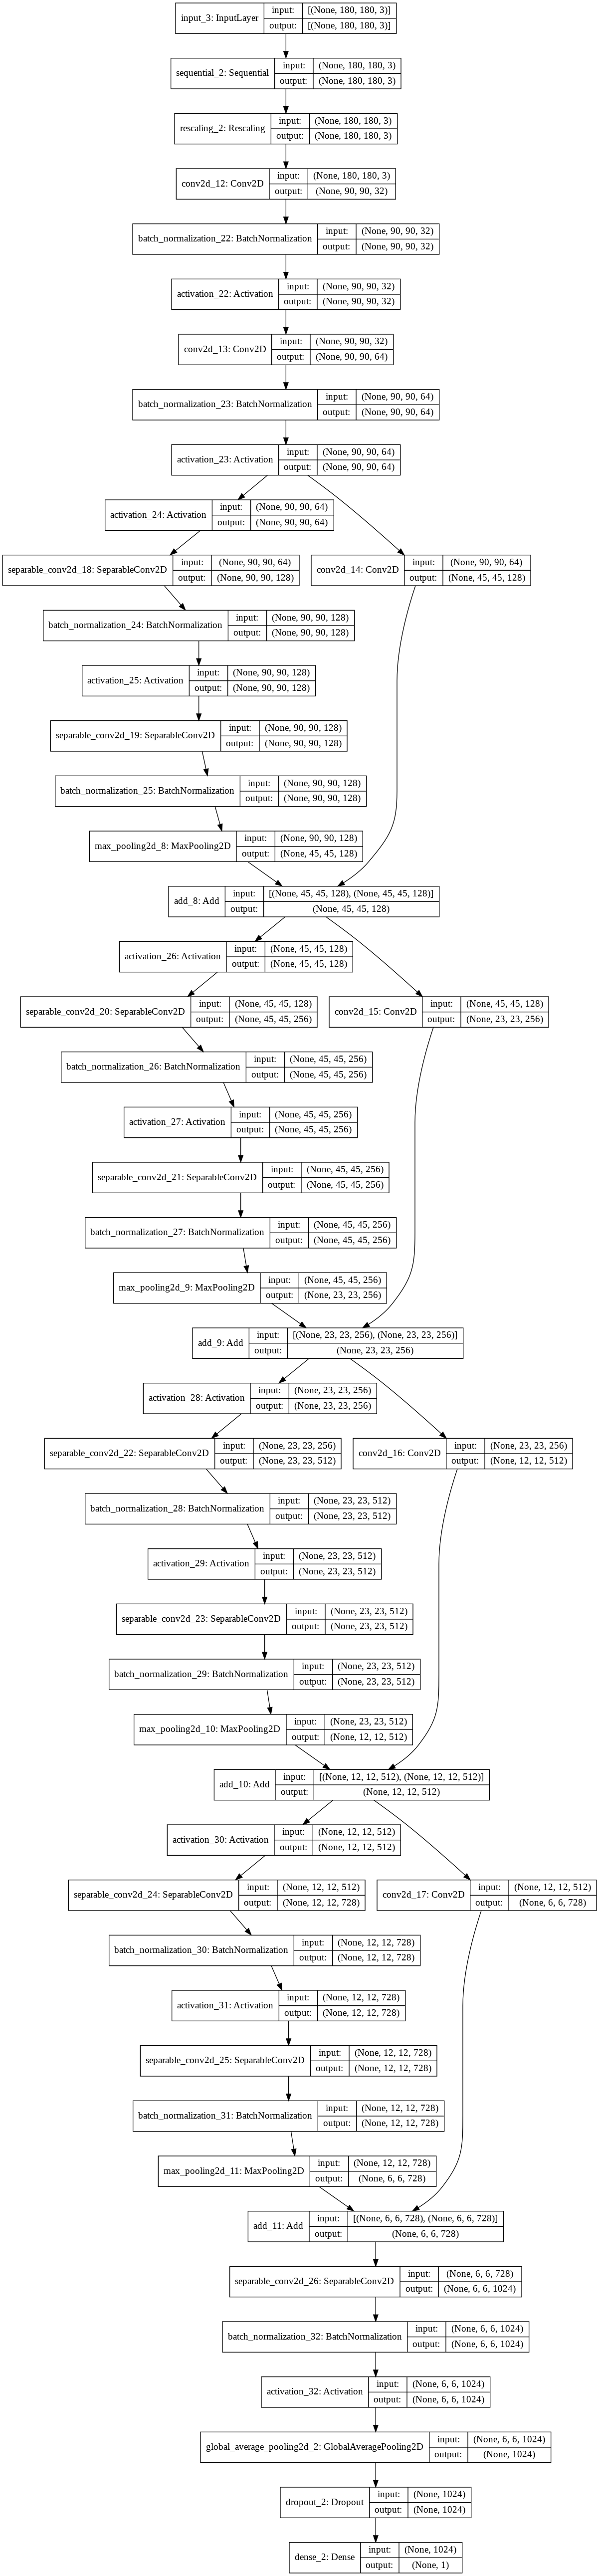

In [32]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block

    # how does the (x) at the end syntax work?
    # this is like layers.add.add.add??

    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else: # isn't dog and cat always 2 classes?
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [33]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

# 586 images * 10 augmentations * 4 sizes and this applies to testing too. way to much
# decreased to 100 images * 3 augmentations * 4 sizes
# still 1200 images total to train!?
# how is it validating/checking accuracy while training?
# it's training a little then testing one and so on?
# loss .77 accuracy .53 still don't know how to read that
# test CPU speed next time. GPU takes 10 minutes per epoch

Epoch 1/10
100/100 [==============================] - 29s 264ms/step - loss: 0.7619 - accuracy: 0.5843 - val_loss: 0.7220 - val_accuracy: 0.4609
Epoch 2/10
100/100 [==============================] - 27s 264ms/step - loss: 0.6613 - accuracy: 0.6267 - val_loss: 0.7830 - val_accuracy: 0.4500
Epoch 3/10
100/100 [==============================] - 26s 260ms/step - loss: 0.6151 - accuracy: 0.6737 - val_loss: 0.8356 - val_accuracy: 0.4437
Epoch 4/10
100/100 [==============================] - 26s 260ms/step - loss: 0.5891 - accuracy: 0.6954 - val_loss: 0.7065 - val_accuracy: 0.4625
Epoch 5/10
100/100 [==============================] - 27s 263ms/step - loss: 0.5342 - accuracy: 0.7315 - val_loss: 0.6660 - val_accuracy: 0.5672
Epoch 6/10
100/100 [==============================] - 26s 261ms/step - loss: 0.4943 - accuracy: 0.7577 - val_loss: 0.6380 - val_accuracy: 0.6109
Epoch 7/10
100/100 [==============================] - 27s 262ms/step - loss: 0.5076 - accuracy: 0.7471 - val_loss: 0.5198 - val_ac

In [34]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 85.13 percent cat and 14.87 percent dog.
